In [2]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
%matplotlib inline
print("Using PyTorch Version %s" %torch.__version__)

Using PyTorch Version 1.6.0


In [4]:
np.random.seed(0)
torch.manual_seed(0)
X, Y = make_moons(500, noise=0.2)

# Split into test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
    test_size=0.25, random_state=73)

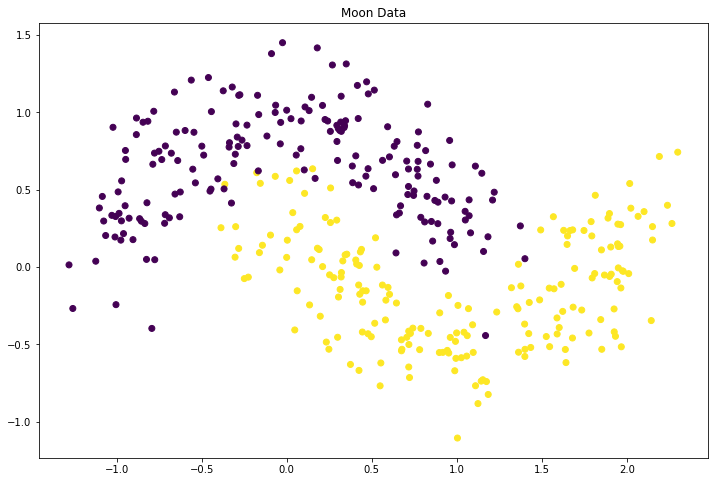

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title('Moon Data')
plt.show()

In [6]:
# Define network dimensions
n_input_dim = X_train.shape[1]
# Layer size
n_hidden = 4 # Number of hidden nodes
n_output = 1 # Number of output nodes = for binary classifier

# Build your network
net = nn.Sequential(
    nn.Linear(n_input_dim, n_hidden),
    nn.ELU(),
    nn.Linear(n_hidden, n_output),
    nn.Sigmoid())
    
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


In [7]:
x = torch.FloatTensor([1, 1])
net(x)

tensor([0.5764], grad_fn=<SigmoidBackward>)

In [9]:
loss_func = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

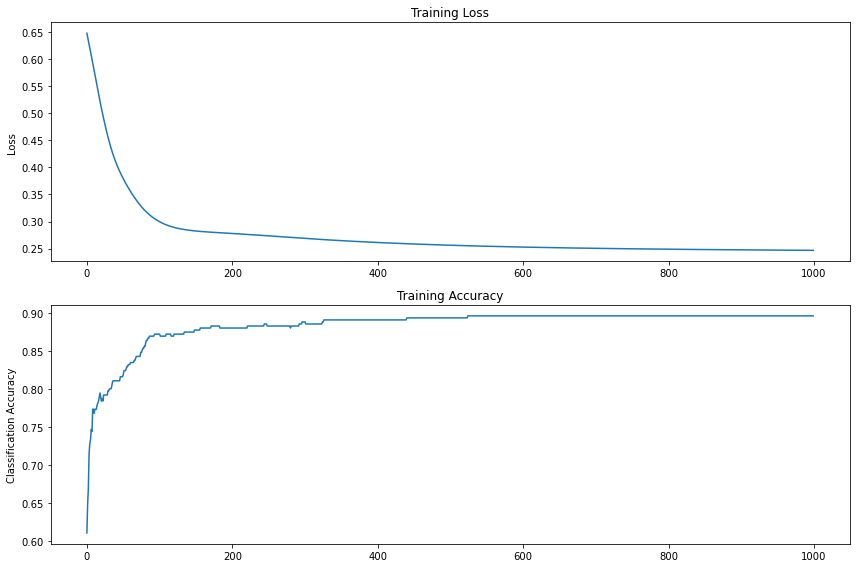

In [10]:
train_loss = []
train_accuracy = []
iters = 1000
Y_train_t = torch.FloatTensor(Y_train).reshape(-1, 1)
for i in range(iters):
    X_train_t = torch.FloatTensor(X_train)
    y_hat = net(X_train_t)
    loss = loss_func(y_hat, Y_train_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(Y_train.reshape(-1,1)==y_hat_class) / len(Y_train)
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())
    
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

Test Accuracy 0.87


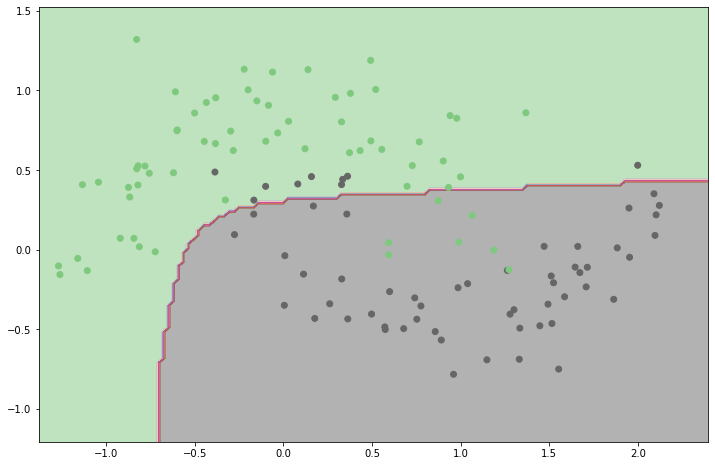

In [11]:
# Pass test data
X_test_t = torch.FloatTensor(X_test)
y_hat_test = net(X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(Y_test.reshape(-1,1)==y_hat_test_class) / len(Y_test)
print("Test Accuracy {:.2f}".format(test_accuracy))

# Plot the decision boundary
# Determine grid range in x and y directions
x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

# Set grid spacing parameter
spacing = min(x_max - x_min, y_max - y_min) / 100

# Create grid
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))

# Concatenate data to match input
data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

# Pass data to predict method
data_t = torch.FloatTensor(data)
db_prob = net(data_t)

clf = np.where(db_prob<0.5,0,1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, 
            cmap=plt.cm.Accent)
plt.show()

In [12]:
class network():
    
    def __init__(self, X, Y, n_hidden=4, learning_rate=1e-2, device='cpu'):
        self.device = device
        self.X = X
        self.Y = Y.reshape(-1,1)
        self.Y_t = torch.FloatTensor(self.Y).to(device=self.device)
        self.n_input_dim = X.shape[1]
        self.n_output = 1
        self.learning_rate = learning_rate
        self.n_hidden = n_hidden
        
        # Build network
        self.net = nn.Sequential(
            nn.Linear(self.n_input_dim, self.n_hidden), 
            nn.ELU(),
            nn.Linear(self.n_hidden, self.n_output),
            nn.Sigmoid())
        
        if self.device == 'cuda':
            self.net.cuda()
        
        self.loss_func = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), 
                                          lr=self.learning_rate)
        
    def predict(self, X):
        # Function to generate predictions based on data
        X_t = torch.FloatTensor(X).to(device=self.device)
        return self.net(X_t)
    
    def calculate_loss(self, y_hat):
        return self.loss_func(y_hat, self.Y_t)
    
    def update_network(self, y_hat):
        self.optimizer.zero_grad()
        loss = self.calculate_loss(y_hat)
        loss.backward()
        self.optimizer.step()
        self.training_loss.append(loss.item())
        
    def calculate_accuracy(self, y_hat_class, Y):
        return np.sum(Y.reshape(-1,1)==y_hat_class) / len(Y)
        
    def train(self, n_iters=1000):
        self.training_loss = []
        self.training_accuracy = []
        
        for i in range(n_iters):
            y_hat = self.predict(X)
            self.update_network(y_hat)
            y_hat_class = np.where(y_hat<0.5, 0, 1)
            accuracy = self.calculate_accuracy(y_hat_class, self.Y)
            self.training_accuracy.append(accuracy)
            
    def plot_training_results(self):
        fig, ax = plt.subplots(2, 1, figsize=(12,8))
        ax[0].plot(self.training_loss)
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')

        ax[1].plot(self.training_accuracy)
        ax[1].set_ylabel('Classification Accuracy')
        ax[1].set_title('Training Accuracy')

        plt.tight_layout()
        plt.show()
        
    def plot_testing_results(self, X_test, Y_test):
        # Pass test data
        y_hat_test = self.predict(X_test)
        y_hat_test_class = np.where(y_hat_test<0.5, 0, 1)
        print("Test Accuracy {:.2f}%".format(
            self.calculate_accuracy(y_hat_test_class, Y_test) * 100))

        # Plot the decision boundary
        # Determine grid range in x and y directions
        x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
        y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

        # Set grid spacing parameter
        spacing = min(x_max - x_min, y_max - y_min) / 100

        # Create grid
        XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))

        # Concatenate data to match input
        data = np.hstack((XX.ravel().reshape(-1,1), 
                          YY.ravel().reshape(-1,1)))

        # Pass data to predict method
        db_prob = self.predict(data)

        clf = np.where(db_prob<0.5,0,1)

        Z = clf.reshape(XX.shape)

        plt.figure(figsize=(12,8))
        plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
        plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, 
                    cmap=plt.cm.Accent)
        plt.show()

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


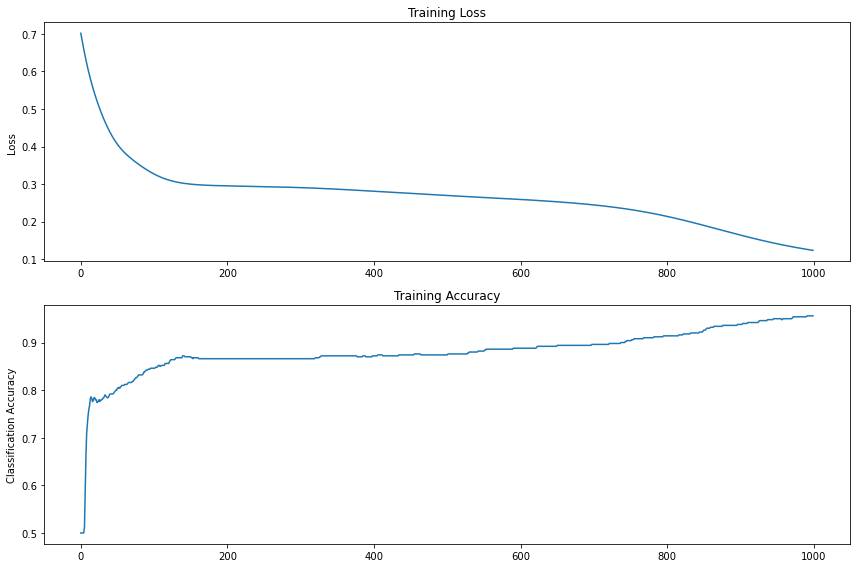

Test Accuracy 92.80%


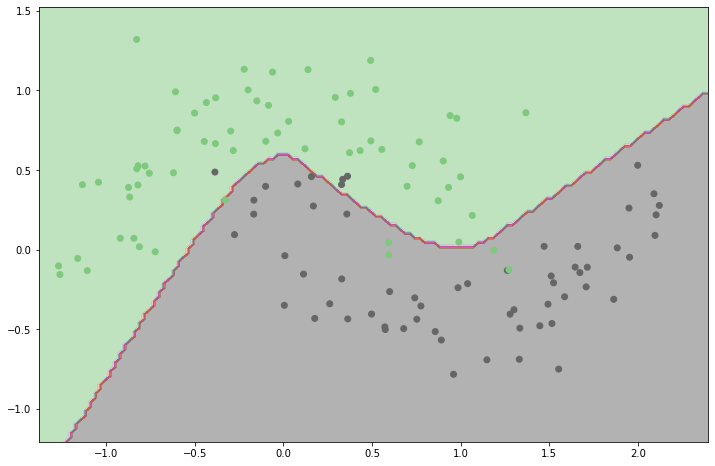

In [13]:
net = network(X, Y)
print(net.net)
net.train()
net.plot_training_results()
net.plot_testing_results(X_test, Y_test)

Number of hidden nodes: 1
Test Accuracy 84.80%


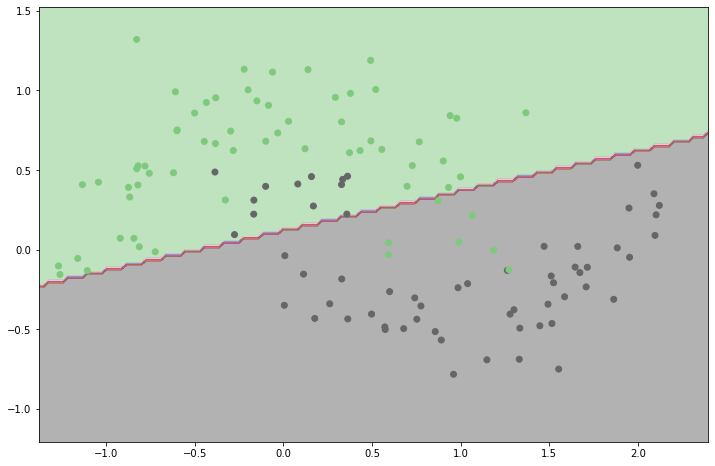

Number of hidden nodes: 5
Test Accuracy 91.20%


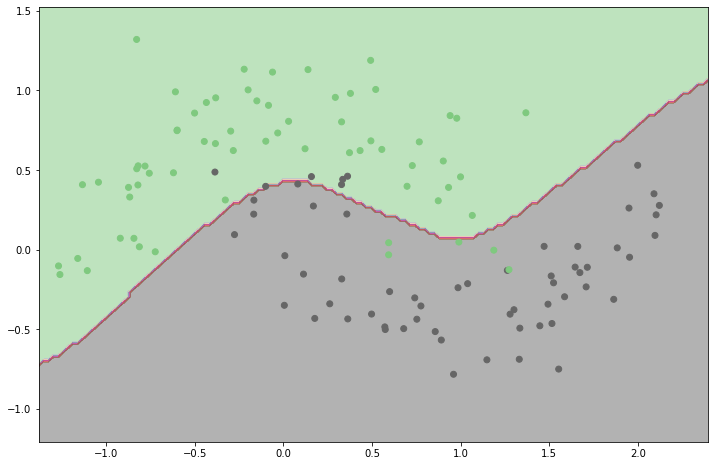

Number of hidden nodes: 10
Test Accuracy 95.20%


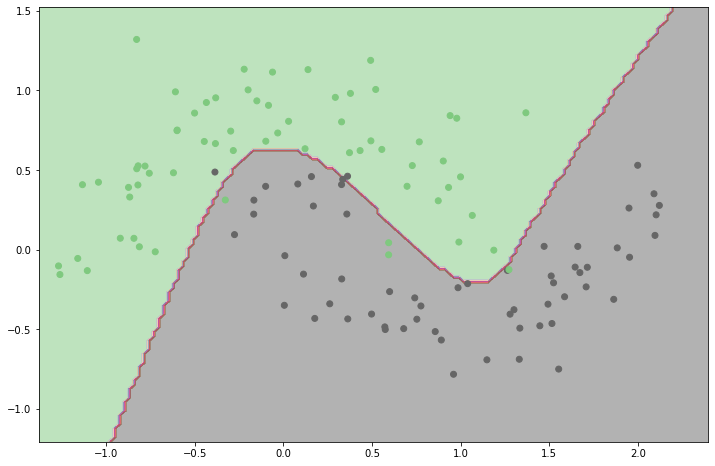

Number of hidden nodes: 25
Test Accuracy 96.00%


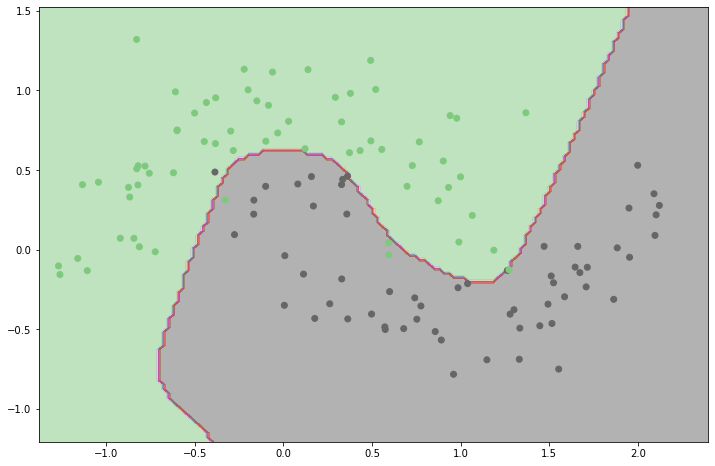

Number of hidden nodes: 50
Test Accuracy 96.80%


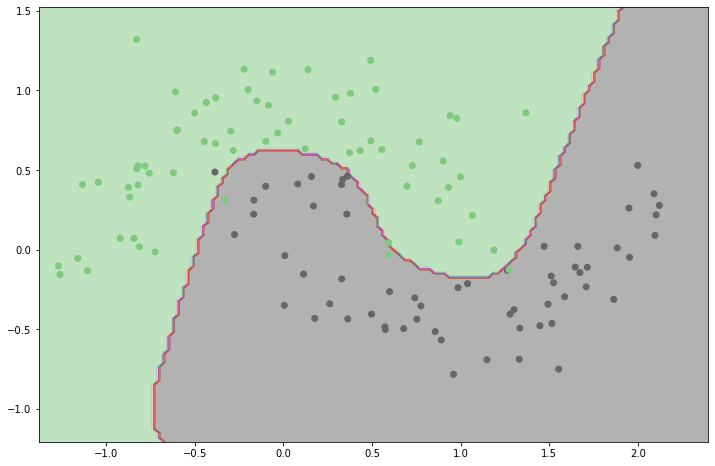

In [14]:
n_hidden_nodes = [1, 5, 10, 25, 50]

for n in n_hidden_nodes:
    print("Number of hidden nodes: {:d}".format(n))
    net = network(X, Y, n_hidden=n)
    net.train()
    net.plot_testing_results(X_test, Y_test)